# **Multimodal Analysis of Emotion and Gender from Speech Audio** #

---
####This notebook is developed by Rahiq Majeed, Cesar Garcia, and Nicholas Vandra.

In this project, we are going to develop deep learning models to classify emotion, speaker identity, and gender from raw speech audio data. Our models are trained on the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). This dataset contains 2820 audio samples from 24 professional voice actors expressing emotions like calm, happiness, sadness, anger, fear, and neutral.

Our goal is three-fold:


*   Accurately classify the emotion in a speech sample into categories like calm, neutral, angry, sad , happy and etc.

*   Accurately classify emotion from speech audio data.

*   Predict the gender of the speaker as male or female.


Solving these tasks has applications in personalized recommendations, conversational agents, and more empathetic human-computer interaction.

# Citation for the dataset

 Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

In [ ]:
# This is just to install the tfio
!pip install -q tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 52.2 MB/s eta 0:00:00


In [ ]:
!pip install pydub

In [ ]:
!pip install soundfile

In [ ]:
!pip install noisereduce

In [ ]:
import numpy as np
import librosa
import IPython.display as ipd
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import glob
import seaborn as sns
from IPython.display import Audio, display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input, Model, Sequential
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Dropout, Dense, Flatten , BatchNormalization, SeparableConv1D, LSTM, GRU, Reshape, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment, effects
from pydub.silence import detect_nonsilent
import noisereduce as nr
from tensorflow.keras.utils import to_categorical
import random
import soundfile as sf
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set paths to input and output data
INPUT_DIR = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/'
OUTPUT_DIR = '/kaggle/working/'

FRAME_SIZE = 2048
HOP_SIZE = 512

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

In [ ]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

##Loading data from GitHub

In [ ]:
!git clone https://github.com/NicVSoftware/Advanced-Machine-Learning-Final-Project.git

Cloning into 'Advanced-Machine-Learning-Final-Project'...
remote: Enumerating objects: 1483, done.
remote: Total 1483 (delta 0), reused 0 (delta 0), pack-reused 1483
Receiving objects: 100% (1483/1483), 213.81 MiB | 25.16 MiB/s, done.
Resolving deltas: 100% (244/244), done.
Updating files: 100% (2821/2821), done.


In [ ]:
base_path = '/content/Advanced-Machine-Learning-Final-Project'
base_path2 = '/content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/'

In [ ]:
wav_files = glob.glob(os.path.join(base_path, '**/*.wav'), recursive=True)
print(f"Total .wav files found: {len(wav_files)}")

Total .wav files found: 2820


In [ ]:
audio_data = []
for file in wav_files:
    audio, sr = librosa.load(file, sr=None)
    audio_data.append((audio, sr))

In [ ]:
print(f"Total audio files loaded: {len(audio_data)}")

Total audio files loaded: 2820


In [ ]:
def get_audio_file_paths(base_path):
  file_paths = []
  ravdess_directory_list = [dir for dir in os.listdir(base_path) if not dir.startswith('.')]

  for dir in ravdess_directory_list:
      actor_dir = os.path.join(base_path, dir)
      if os.path.isdir(actor_dir):
          actor_files = os.listdir(actor_dir)
          for file in actor_files:
              if file.endswith('.wav'):
                  file_paths.append(os.path.join(actor_dir, file))

  return file_paths

In [ ]:
labels = []
for file in wav_files:
    parts = file.split('_')
    labels.append(parts[0])

##Data Exploration

The Data Exploration process involves setting the base path of the dataset to a variable named Data_frame and listing all directories in the Ravdess dataset, excluding hidden files or directories. Two empty lists, file_emotion and file_path, are initialized to store the emotion associated with each file and the file's path. For each directory, the emotion is extracted from the filename, and the file's path is appended to the file_emotion list. Two dataframes, emotion_df and path_df, are created for the emotions and paths of the files. The Emotions column of df_1 is replaced with their corresponding emotion names, and the output shows the emotion associated with each.wav file and its path, indicating successful categorization of audio files based on their emotion.

In [ ]:
Data_frame = base_path

# Ensure there's a trailing slash
if not Data_frame.endswith('/'):
    Data_frame += '/'

# List the directories in the Ravdess dataset
ravdess_directory_list = [dir for dir in os.listdir(Data_frame) if not dir.startswith('.')]

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # As there are different actors in the directory, we need to extract files for each actor.
    actor_dir = Data_frame + dir
    if os.path.isdir(actor_dir):  # Check if it's a directory
        actor = os.listdir(actor_dir)
        for file in actor:
            if file.endswith('.wav'):  # Check if the file is a .wav file
                part = file.split('.')[0]
                part = part.split('-')
                # Ensure that 'part' has enough elements to prevent IndexError
                if len(part) >= 3:
                    # The third part in each file represents the emotion associated with that file.
                    file_emotion.append(int(part[2]))
                    file_path.append(actor_dir + '/' + file)
                else:
                    print(f"Filename {file} in directory {dir} does not match expected format.")

# Create a dataframe for the emotions of the files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for the paths of the files
path_df = pd.DataFrame(file_path, columns=['Path'])
df_1 = pd.concat([emotion_df, path_df], axis=1)

# Map the integer labels to actual emotion names
df_1.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

# Display the first few entries of the dataframe
df_1.head()

Emotions                                               Path
0       sad  /content/Advanced-Machine-Learning-Final-Proje...
1     happy  /content/Advanced-Machine-Learning-Final-Proje...
2  surprise  /content/Advanced-Machine-Learning-Final-Proje...
3      calm  /content/Advanced-Machine-Learning-Final-Proje...
4      fear  /content/Advanced-Machine-Learning-Final-Proje...

Repurposed code from Kaggle project Speech Emotion Recognition 90% by Gem. In order to store list of gender, emotion and path in a dataframe for simple access. https://www.kaggle.com/code/gemmin/speech-emotion-recognition-90

In [ ]:
ravdess_dir_list = os.listdir(base_path2)
path_list = []
gender_list = []
emotion_list = []

# Updated emotion dictionary
emotion_dic = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

for directory in ravdess_dir_list:
    actor_files = os.listdir(os.path.join(base_path2, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{base_path2}{directory}/{audio_file}")
            gender_list.append('female' if gender_code % 2 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
        else:
            print(f"Unrecognized emotion code '{key}' in file: {audio_file}")

ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()
df = ravdess_df

This section of Data Exploration explains how to extract emotion and gender information from audio samples in a dataset. Using an updated dictionary, the method entails listing all folders in the base path, separating the filename into parts, and mapping the two-digit code to the real emotion name. The seventh portion of the filename determines the gender, with 'female' if the number is even and'male' otherwise. The audio file URLs, genders, and emotions are saved in distinct lists, and ravdess_df is formed by concatenating these lists along the column axis. The dataframe represents the RAVDESS dataset in an organized manner, with each row corresponding to each audio file and columns for the file's directory and speaker's gender, and emotion that is portrayed in the audio.

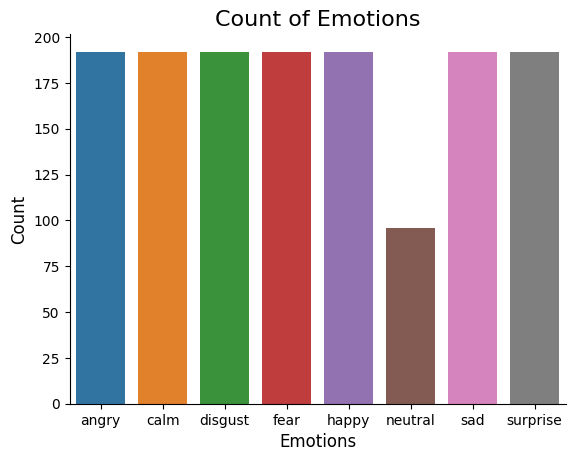

In [ ]:
df_1.Emotions = df_1.Emotions.astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(x=df_1.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

The grpah which we have created above is a count plot  that displays the distribution of different emotions in your dataset. Each bar represents an emotion, and the height of the bar indicates the count of that emotion in the dataset. The emotions are categorized as 'angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', and 'surprise'.

The title “Count of Emotions” clearly indicates what the graph represents, and the x-axis labeled “Emotions” lists the types of emotions, while the y-axis labeled “Count” shows the number of occurrences. The sns.despine() function has been used to remove the top and right borders of the plot, giving it a cleaner look by only showing the bottom and left spines.

Overall, this visualization helps us in understanding the frequency of each emotion in our dataset, which will be used for tasks like emotion analysis or building emotion recognition models later in the notebook.

In [ ]:
plt.style.use('ggplot')

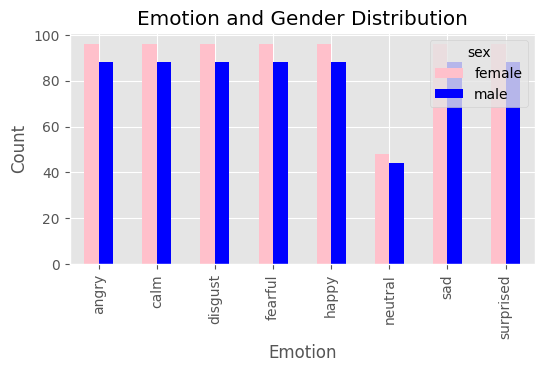

In [ ]:
def plot_distribution(df):
  countTable = df.groupby(['emotion', 'sex']).count()
  pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

  pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
  plt.title('Emotion and Gender Distribution')
  plt.xlabel('Emotion')
  plt.ylabel('Count')
  plt.show()

plot_distribution(df)

To analyze a dataset, we grouped the dataframe by 'emotion' and 'sex' columns and created a count table. After that, we pitched this to a pivot table with 'emotion' as the index and'sex' as the columns. The values represent the count of each emotion for each gender. Then we plotted the pivot table as a bar graph, colored pink for 'female' and blue for'male'. This provides a clear visual representation of the distribution of emotions and gender, aiding in exploratory data analysis.

In [ ]:
def plot_waveform(data, sr, title):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {title} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [ ]:
def plot_spectrogram(file_path, sr, title="Spectrogram"):
    S_trace = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    Y_trace = librosa.power_to_db(np.abs(S_trace) ** 2)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Y_trace, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show();

The following notebook section analyzes the audio files associated with the different emotions given in the RAVDESS dataset.  As seen above, the emotions being analzyed are fear, angry, sad, happy, surprise, calm, and disgust. There is both a waveform and spectrogram to visualize the audio data. The audio player is displayed, allowing the user to listen to the file directly in the notebook.

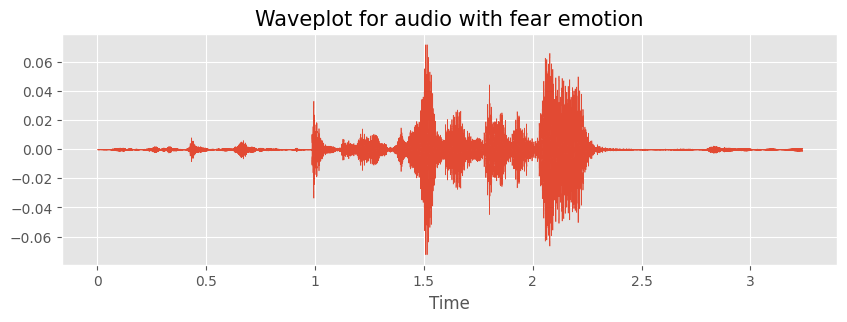

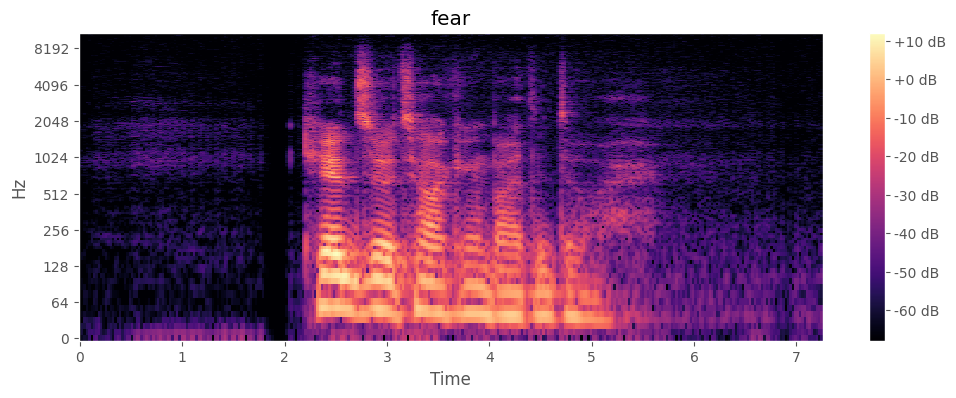

In [ ]:
emotion_to_path_dict = df_1.set_index('Emotions')['Path'].to_dict()

# For 'fear' emotion
emotion = 'fear'
path = emotion_to_path_dict.get(emotion)
if path:
  data, sampling_rate = librosa.load(path)
  plot_waveform(data, sampling_rate, emotion)
  print('')
  plot_spectrogram(data, sampling_rate, emotion)
  print('')
  print('')
  display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

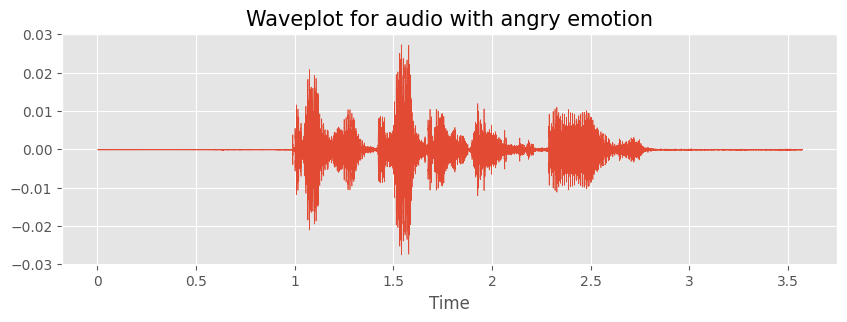

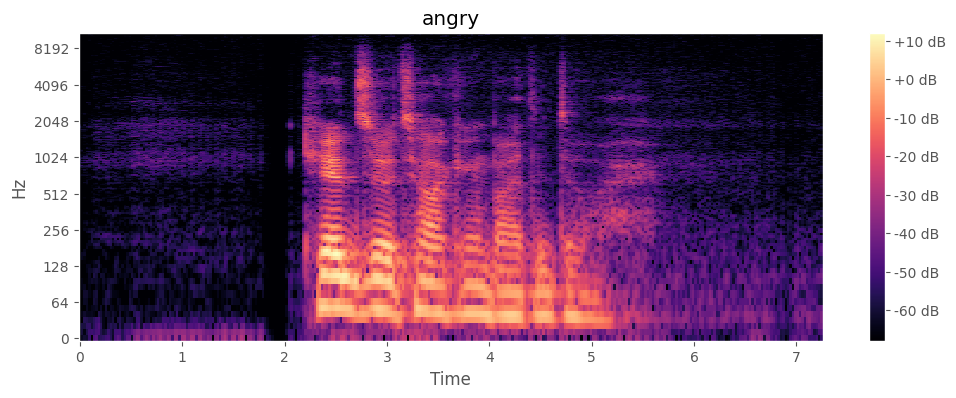

In [ ]:
emotion = 'angry'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

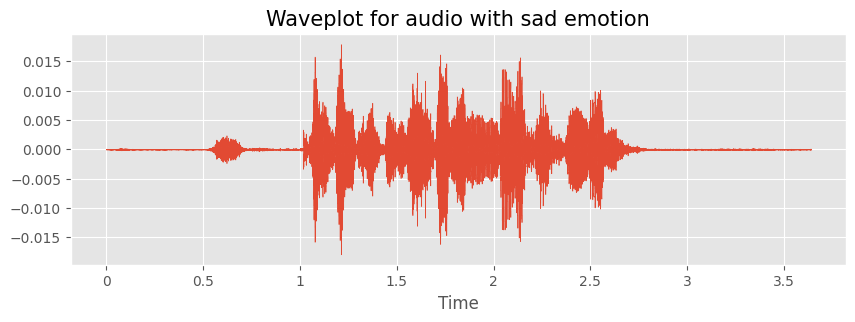

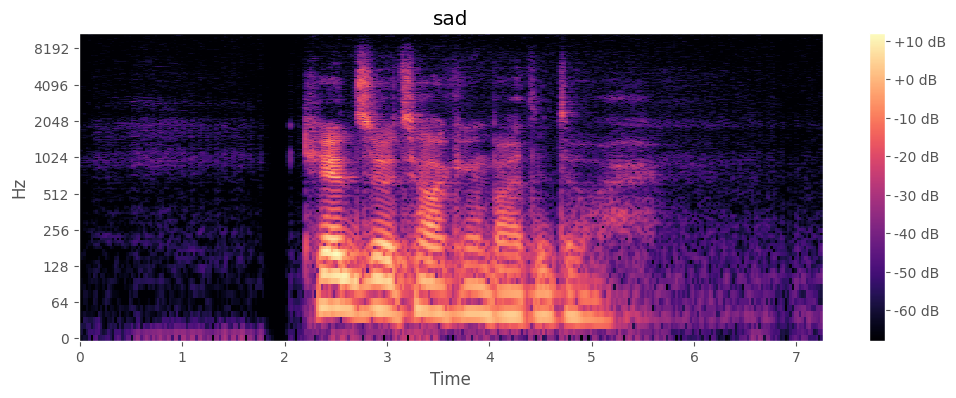

In [ ]:
emotion = 'sad'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

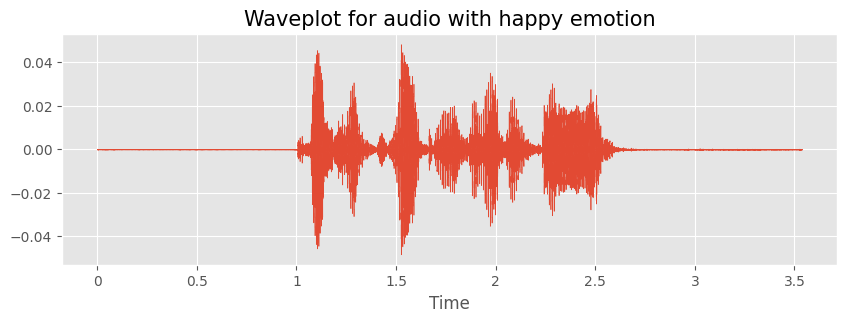

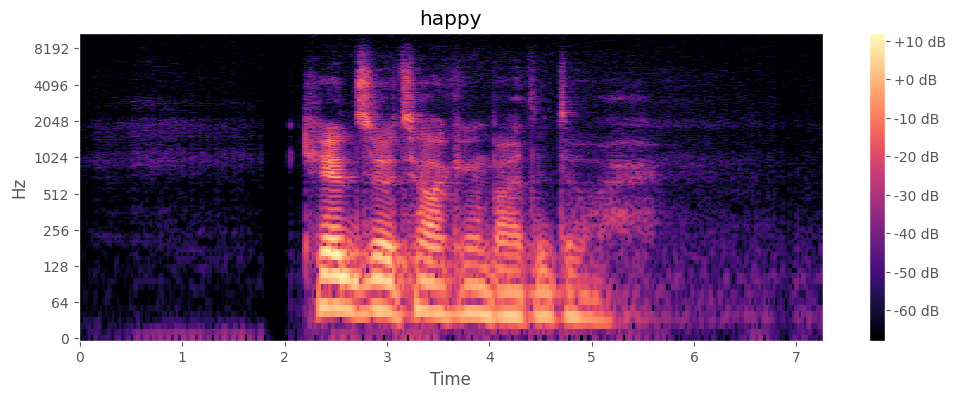

In [ ]:
emotion = 'happy'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

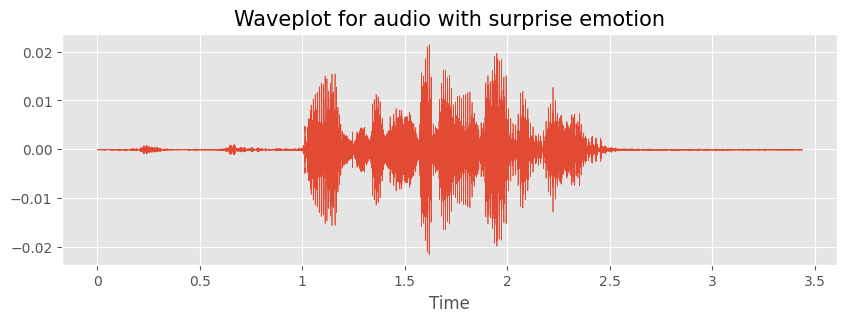

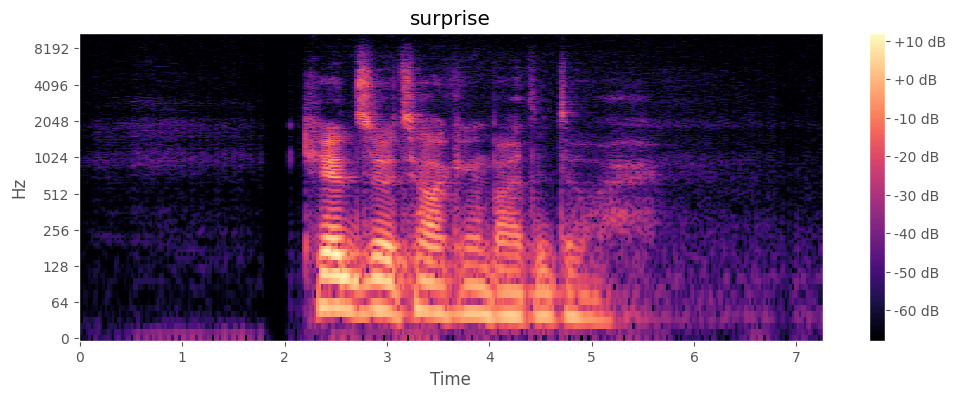

In [ ]:
emotion = 'surprise'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

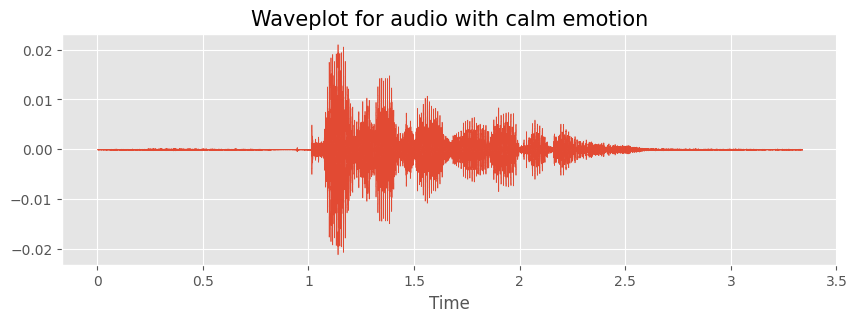

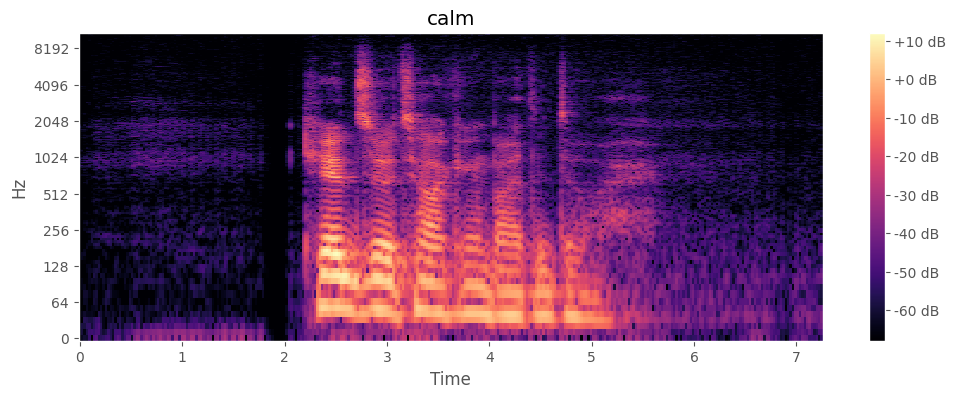

In [ ]:
emotion = 'calm'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

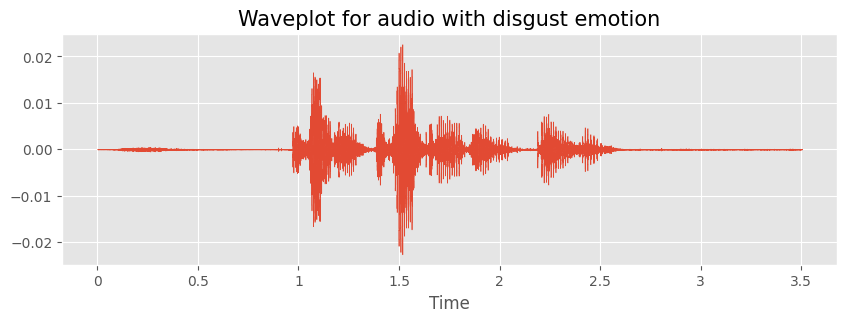

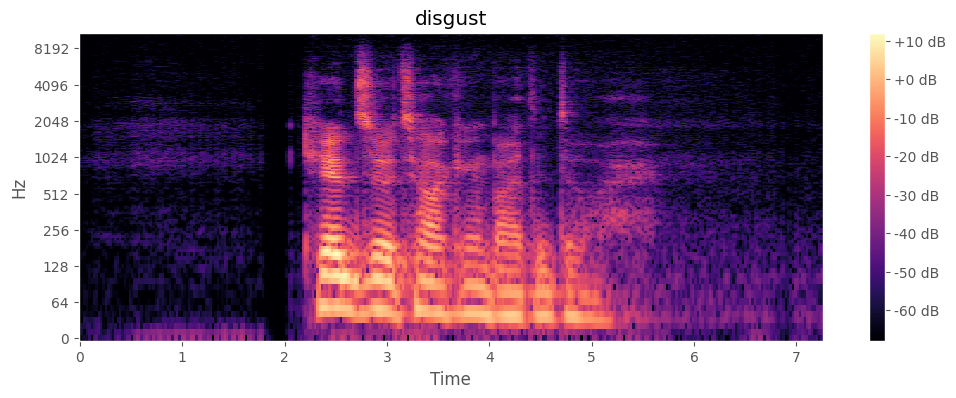

In [ ]:
emotion = 'disgust'
path = emotion_to_path_dict.get(emotion)
if path:
    data, sampling_rate = librosa.load(path)
    plot_waveform(data, sampling_rate, emotion)
    print('')
    plot_spectrogram(data, sampling_rate, emotion)
    print('')
    display(Audio(path))
else:
    print(f"No audio file found for emotion: {emotion}")

### Conclusion of waveforms and spectogram

---


The waveform plot in all the graphs above provides a visual representation of the sound pressure level of the audio signal as it varies with time. The spectrogram plot provides a visual representation of the spectrum of frequencies in the audio signal as they vary with time, which is useful for analyzing the audio's pitch and timbre characteristics.

##Data Cleaning

In [ ]:
def remove_silence(file_path, sr, top_db=20):
    non_silent_intervals = librosa.effects.split(audio, top_db=top_db)
    clean_audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
    return clean_audio

The method remove_silence removes the quiet sections from an audio file. This phase is critical in audio preprocessing, allowing us to focus on sound-containing regions.

In [ ]:
clean_audio_data = []
for audio, sr in audio_data:
    clean_audio = remove_silence(audio, sr)
    clean_audio_data.append((clean_audio, sr))

In [ ]:
first_clean_audio, first_sr = clean_audio_data[0]
display(Audio(first_clean_audio, rate=first_sr))

##Data Preprocessing

In [ ]:
def normalize_audio(audio):
    return librosa.util.normalize(audio)

This is a common preprocessing step in audio processing to normalize audio files between -1 and 1, making it more suitable for further analysis.

In [ ]:
def pad_audio(audio, max_length):
    # Ensure the audio is padded or truncated to 'max_length'
    padded_audio = librosa.util.fix_length(audio, size=max_length)
    return padded_audio

The function pad_audio uses the librosa.util.fix_length function to verify that an audio file has the appropriate length. It requires two parameters: audio and max_length. If the audio is shorter than max_length, it is padded with zeros to achieve max_length, and if it is longer, it is trimmed to max_length.

In [ ]:
def extract_features(audio, sr):
    # Pass the audio data and sampling rate as keyword arguments
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr)
    return mfccs_features.T  # Transpose for having time steps as rows and features as columns

The function extract_features extracts features from an audio file using the librosa.feature.mfcc function. It uses audio data and sampling rate sr to compute Mel-frequency cepstral coefficients (MFCCs), a feature used in speech and audio processing. MFCCs provide a compact representation of the audio spectrum, useful for tasks like speech recognition and emotion recognition. The function returns a 2D array with different MFCCs and time steps.

In [ ]:
preprocessed_data = []
max_length = max(len(audio) for audio, sr in clean_audio_data)  # Find the max length of audio in the dataset
for audio, sr in clean_audio_data:
    normalized_audio = normalize_audio(audio)
    padded_audio = pad_audio(normalized_audio, max_length)
    features = extract_features(padded_audio, sr)
    preprocessed_data.append(features)

In [ ]:
df_features = pd.DataFrame([features.flatten() for features in preprocessed_data])

With the assistance of ChatGPT, this function was designed to process raw audio input. It  removes silent segments, standardizes the length and sampling rate of the audio, and normalizes its volume.
In detail, the function loads an audio file, detects and excludes extended silent portions, and then adjusts the audio to a uniform length. The length of the audio is important so our memory is not crammed with the raw input data. If the audio is longer than the target length, it is trimmed; if shorter, it's padded with silence.

 This preprocessing is has crucial for preparing raw audio data as our model would have troubles if the audio inputs are not uniform in length, there are still some exceptions where the data does not get preprocessed well, which is only about 5 instances but they are entirely dropped and not used for our models.

In [ ]:
def preprocess_audio(path, target_length_ms=3000, silence_thresh=-50, min_silence_len=500, standard_frame_rate=48000):
    """
    Preprocess audio by removing silence, downsampling, normalizing, and then padding/trimming to target length in milliseconds.

    Parameters:
    path (str): Path to the audio file.
    target_length_ms (int): Target length of the audio in milliseconds.
    silence_thresh (int): Threshold for silence detection. Lower values mean more aggressive trimming.
    min_silence_len (int): Minimum length of silence to consider for splitting.
    standard_frame_rate (int): The standard frame rate to downsample the audio.

    Returns:
    np.array: Processed audio samples.
    """
    audio = AudioSegment.from_file(path)

    # Detect non-silent chunks
    nonsilent_chunks = detect_nonsilent(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)

    # Concatenate non-silent chunks
    processed_audio = AudioSegment.empty()
    for start, end in nonsilent_chunks:
        processed_audio += audio[start:end]

    # Adjust the length of the audio
    current_length = len(processed_audio)
    if current_length > target_length_ms:
        processed_audio = processed_audio[:target_length_ms]
    elif current_length < target_length_ms:
        silence_duration = target_length_ms - current_length
        silence = AudioSegment.silent(duration=silence_duration)
        processed_audio += silence

    # Downsample the audio to the standard frame rate
    processed_audio = processed_audio.set_frame_rate(standard_frame_rate)

    # Convert to numpy array
    samples = np.array(processed_audio.get_array_of_samples()).astype('float32')

    # Normalize the audio
    samples = librosa.util.normalize(samples)

    # Calculate the target length in samples and pad if necessary
    target_length_samples = (target_length_ms * standard_frame_rate) // 1000
    samples = np.pad(samples, (0, max(0, target_length_samples - len(samples))), 'constant')

    return samples

This Python function, preprocess_audio, performs several preprocessing steps on an audio file. It starts by loading the audio file from a specified path and detecting non-silent chunks using the detect_nonsilent() function. The function then concatenates non-silent chunks to form the processed audio. If the audio is longer than the target length, it is trimmed to the target length, and if shorter, silence is added until it reaches the target length. The processed audio is then downsampled to a standard frame rate using the set_frame_rate() method. The processed audio is then converted into a numpy array of samples, which are normalized using the librosa.util.normalize() function. Finally, the function calculates the target length in samples and pads the audio if necessary to reach this length. The function returns the processed audio samples as a numpy array, which is useful for preparing audio data for our model.

In [ ]:
def preprocess_audio_hybrid(file_path):
  audio, sr = librosa.load(file_path, sr=None)
  audio = librosa.util.normalize(audio)
  audio = nr.reduce_noise(y=audio, sr=sr)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
  return mfccs

In [ ]:
def postprocess_audio(audio, sr, min_length):
  if len(audio) < min_length:
      padding = min_length - len(audio)
      audio = np.pad(audio, (0, padding), 'constant')
  return audio

In [ ]:
mfccs = preprocess_audio_hybrid(wav_files[0])

In [ ]:
def preprocess_audio_pipeline(audio, sr, max_length):
  audio = remove_silence_hybrid(audio, sr)
  audio = pad_audio_hybrid(audio, max_length)

  return audio

### Data Augmentation

Data augmentation is needed when dealing with audio data for many reasons, one that we try to target is to increase the dataset size and diversity and having a simulation of real world variation. Hence why we implemented these functions below that augment the data to less uniform and have some variance.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = int(pitch_factor* 12)
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

The functions describes various data augmentation techniques used to enhance the diversity of data available for training models. The functions include noise(data), stretch(data, rate=0.8), shift(data), and pitch(data, sampling_rate, pitch_factor=0.7).

*   Noise function adds random noise to the audio data, with an amplitude of 3.5% of the maximum amplitude.  
*   Stretch function stretches or contracts the audio data in time, with a rate parameter determining the rate.
* Shift function shifts the audio data in time, with a range of -5000 to 5000, using the numpy.roll function.
* Finally, pitch changes the pitch of the audio data, with a pitch factor determining the number of half-steps to shift the pitch.




####Augmentation Examples

Below are some examples of how the data augmentation changes our raw audio, with pitch, noise, shift, and stretch. Each example contains the same audio file with just the applied augmentation, which can shows the amount of variation we can add to our data when applying them.

In [ ]:
emotion_to_path_dict = df_1.set_index('Emotions')['Path'].to_dict()

In [ ]:
emotion = 'sad'
path = emotion_to_path_dict.get(emotion)

data, sampling_rate = librosa.load(path)

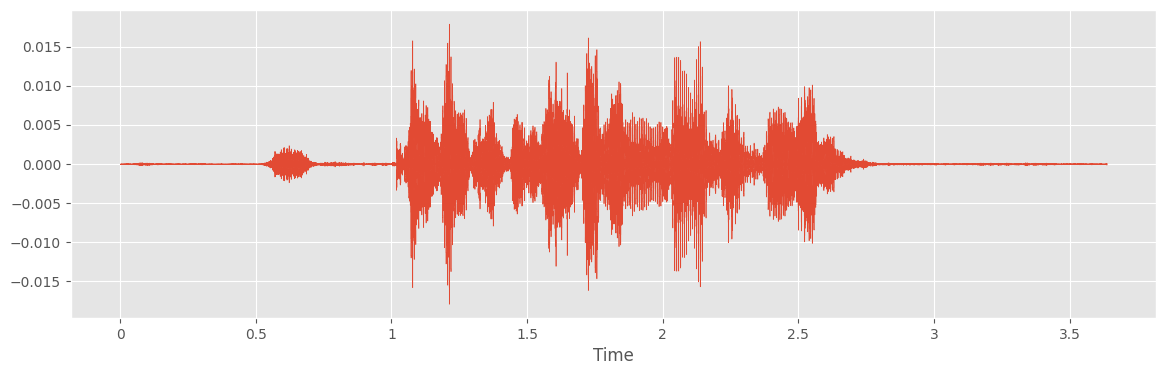

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sampling_rate)
Audio(path)

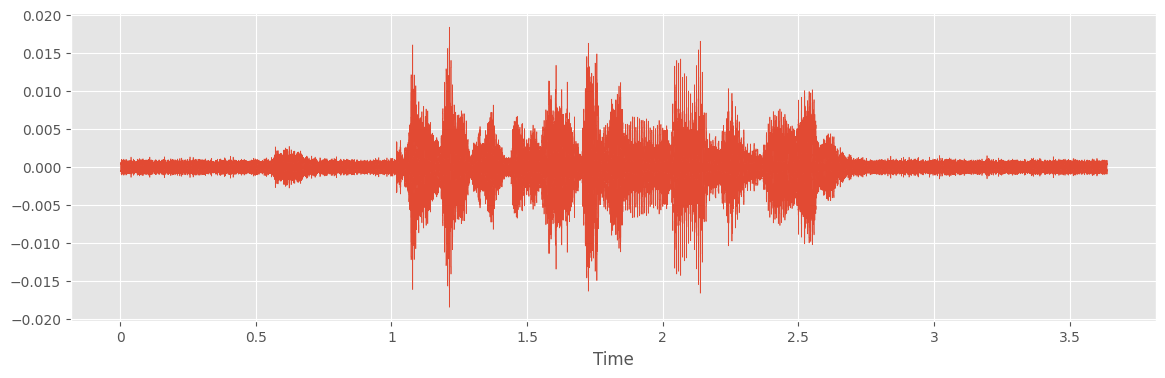

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

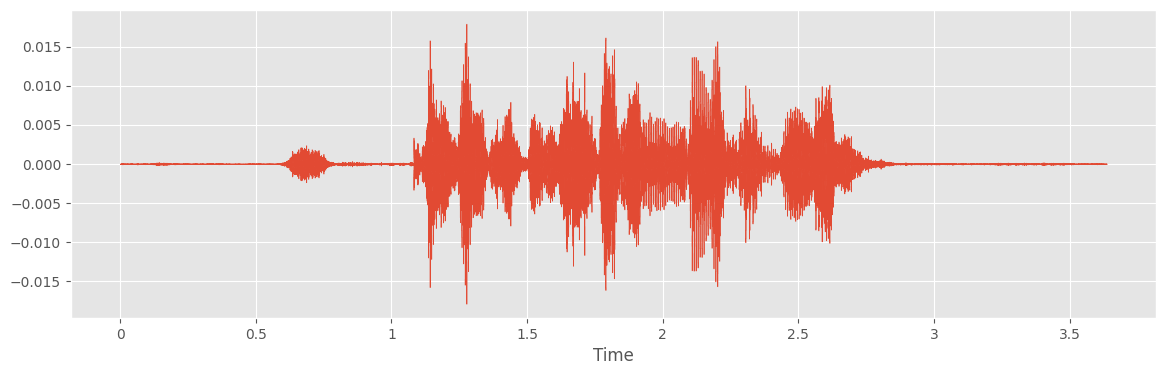

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

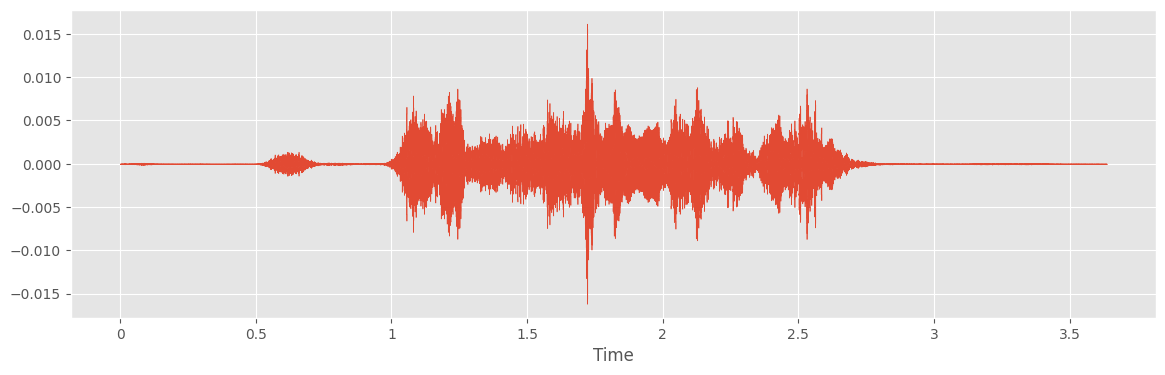

In [ ]:
x = pitch(data, sampling_rate, pitch_factor=0.7)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

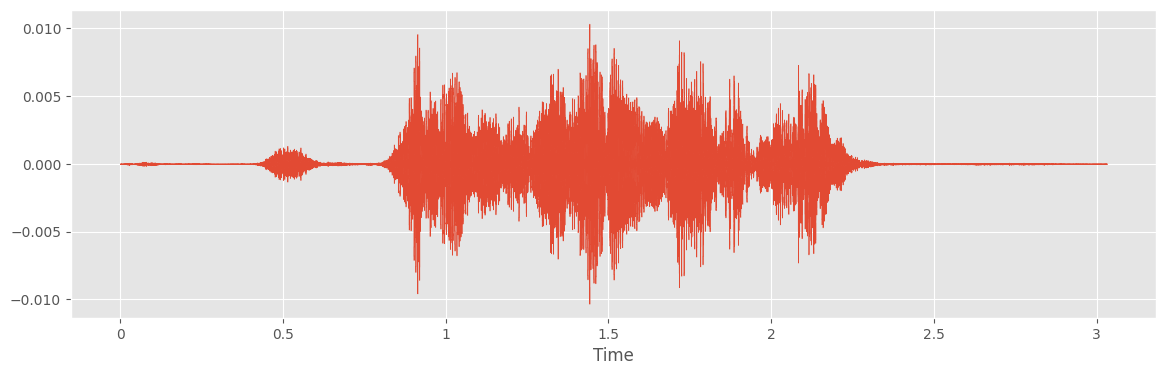

In [ ]:
x = stretch(data , rate = 1.2)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [ ]:
###

In [ ]:
def pad_audio_hybrid(audio, desired_length):
  if len(audio) < desired_length:
      padding = desired_length - len(audio)
      audio = np.pad(audio, (0, padding), 'constant')
  return audio

In [ ]:
def remove_silence_hybrid(audio, sr, top_db=30):
  non_silent_indices = librosa.effects.split(audio, top_db=top_db)
  non_silent_audio = np.concatenate([audio[start:end] for start, end in non_silent_indices])
  return non_silent_audio

In [ ]:
def augment_audio(audio, sr, pitch_factor=0.5, speed_factor=0.8, noise_level=0.005, shift_max=0.1):
  augmentation_methods = ['pitch_shift', 'time_stretch', 'add_noise', 'shift_audio']
  selected_method = random.choice(augmentation_methods)

  if selected_method == 'pitch_shift':
      audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=pitch_factor)

  elif selected_method == 'time_stretch':
      audio = librosa.effects.time_stretch(y=audio, rate=speed_factor)

  elif selected_method == 'add_noise':
      noise = np.random.randn(len(audio))
      audio = audio + noise_level * noise
      audio = librosa.util.normalize(audio)

  elif selected_method == 'shift_audio':
      shift = np.random.randint(sr * shift_max)
      direction = np.random.randint(0, 2)
      if direction == 1:
          shift = -shift
      audio = np.roll(audio, shift)
      if shift > 0:
          audio[:shift] = 0
      else:
          audio[shift:] = 0

  return librosa.util.normalize(audio)

This function was developed with the help of ChatGPT. The goal of the function is to adjust an audio feature so that it can have a uniform size which is required for some models as they need a consistent shape.

In [ ]:
def pad_or_truncate(feature, max_length):
  current_length = feature.shape[1]
  if current_length < max_length:
      pad_width = max_length - current_length
      feature = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)
  elif current_length > max_length:
      feature = feature[:, :max_length]
  return feature

These functions were developed with the help of ChatGPT.

## Feature Extraction

When exploring notebooks for audio specific projects, we concluded that most projects did not use the raw audio input, nor was the data augmented and then concatenate to the original data to have more data to pass through the model. But what was noiticed was that they used feature extractions.

With these observations we decided to explore what feature extraction was, as in class it glossed over with Fourier Transform as a method of feature extraction that was converting a time-domain signal into a representation of the frequencies that make up the sound. When doing a short deep dive on feature extraction in audio processing we saw that it was transforming raw audio data into a set of more manageable and informative features for the model. Then from the help of the project BirdCLEF:LIBROSA Audio Feature Extraction by Shreya Sajal (https://www.kaggle.com/code/shreyasajal/birdclef-librosa-audio-feature-extraction) and the deep dive of what specific extracted features can include:



*   Spectral Features: Such as Mel-frequency cepstral coefficients (MFCCs), which capture the timbral/textural aspects of sound.
*   Rhythm and Tempo Features: Measuring aspects like beats per minute.
*   Harmony Features: Such as chroma features, which relate to the chords and melody.







In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sampling_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

The extract_features function takes features from audio input and augments it with data to produce a varied dataset for model training. It calculates Zero Crossing Rate (ZCR), Chroma Frequencies, Mel-Frequency Cepstral Coefficients (MFCCs), Root Mean Square Value (RMSV), and MelSpectrogram. The get_features function takes an audio file and extracts features from the original and enhanced versions before returning all features. The audio data is enhanced by adding noise, extending it, and modifying the pitch. These processes can be used to prepare audio data for machine learning applications such as speech emotion recognition. The performance of our model can be possibly enhanced by extracting important characteristics and enriching data. The extract_features and get_features functions were critical in preparing our audio data for further steps.

In [ ]:
def extract_features_hybrid(audio, sr, n_mfcc=13, n_mels=128, n_fft=2048, hop_length=512):
  audio = librosa.util.normalize(audio)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
  chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
  mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
  contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
  tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)

  max_length = max(mfccs.shape[1], chroma.shape[1], mel.shape[1], contrast.shape[1], tonnetz.shape[1])

  mfccs = pad_or_truncate(mfccs, max_length)
  chroma = pad_or_truncate(chroma, max_length)
  mel = pad_or_truncate(mel, max_length)
  contrast = pad_or_truncate(contrast, max_length)
  tonnetz = pad_or_truncate(tonnetz, max_length)

  return np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis=0)

This function was developed with the help of StackoverFlow and ChatGPT. The above function extracts a combination of different audio features. In short, this function normalizes the audio data, extracts MFCCS, chroma, mel spectrogram, contrast, and tonnetz features. It also determines the maximum length, pads or truncates, and then concatenates all of those features.



In [ ]:
X, Y = [], []
for path, emotion in zip(df_1.Path, df_1.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
len(X), len(Y), df_1.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.249910  0.614003  0.563204  0.511174  0.545427  0.568757  0.503854   
1  0.329820  0.729462  0.711669  0.677908  0.706460  0.737662  0.609032   
2  0.163560  0.474750  0.456156  0.424194  0.522989  0.614675  0.560186   
3  0.183209  0.421660  0.448095  0.523680  0.579599  0.500540  0.495273   
4  0.309833  0.600120  0.656900  0.734420  0.759178  0.678744  0.591152   

          7         8         9  ...       153       154       155       156  \
0  0.457886  0.507755  0.613543  ...  0.000037  0.000036  0.000102  0.000146   
1  0.558159  0.634162  0.690195  ...  0.000159  0.000158  0.000222  0.000258   
2  0.509612  0.522882  0.533980  ...  0.000006  0.000010  0.000008  0.000011   
3  0.414148  0.352529  0.436937  ...  0.000152  0.000160  0.000186  0.000203   
4  0.527002  0.479407  0.522704  ...  0.008189  0.007773  0.007772  0.008177   

        157       158       159       160           161  labels  
0  0.000098  0.000113  0.000102  0.000058  4.646427e-06     sad  
1  0.000209  0.000220  0.000213  0.000183  1.228207e-04     sad  
2  0.000012  0.000006  0.000005  0.000002  7.002971e-08     sad  
3  0.000282  0.000340  0.000478  0.000164  1.489313e-05   happy  
4  0.008312  0.008600  0.008221  0.007896  7.539747e-03   happy  

[5 rows x 163 columns]

In feature extraction part, we have applied data augmentation and extracted the features for each audio files and saved them.

###Baseline accuracy for Emotion Classification

In [ ]:
counts = df_1['Emotions'].value_counts()/df_1.shape[0]
print('Baseline accuracy: {:0.4f}'.format(counts[0]))

Baseline accuracy: 0.1333


#Initial Model with Raw Audio

The goal of this model is to achieve baseline performance with raw audio, nothing but fitting the audio into a uniform length to be used in the model and normalization of the audio is done.

In [ ]:
X = []
y = []

for path, label in zip(df['path'], df['emotion']):
    processed_audio = preprocess_audio(path)
    if len(processed_audio) == 144000:
        X.append(processed_audio)
        y.append(label)
    else:
        print(f"Skipping file {path} due to inconsistent length: {len(processed_audio)} samples")

X = np.array(X)
y = np.array(y)

Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_05/03-01-02-01-02-02-05.wav due to inconsistent length: 287986 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav due to inconsistent length: 287984 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_20/03-01-03-01-02-01-20.wav due to inconsistent length: 287986 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_01/03-01-08-01-02-02-01.wav due to inconsistent length: 287990 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02-01.wav due to inconsistent length: 287992 samples


In [ ]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1100, 144000), (1100, 8), (275, 144000), (275, 8))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1100, 144000, 1), (1100, 8), (275, 144000, 1), (275, 8))

In [ ]:
print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of x_train:", y_train.shape)
print("Shape of x_test:", y_test.shape)

Shape of x_train: (1100, 144000, 1)
Shape of x_test: (275, 144000, 1)
Shape of x_train: (1100, 8)
Shape of x_test: (275, 8)


In [ ]:
K.clear_session()

In [ ]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143998, 32)        128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 71999, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35999, 32)         3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 17999, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8999, 32)          3104      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4499, 32)          0

In [ ]:
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.2,
  patience=5,
  min_lr=0.0000001,
  verbose=1
)

In [ ]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping , reduce_lr])

Epoch 1/50
35/35 [==============================] - 19s 185ms/step - loss: 2.0713 - accuracy: 0.1364 - val_loss: 2.0607 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 5s 149ms/step - loss: 2.0294 - accuracy: 0.1718 - val_loss: 1.9972 - val_accuracy: 0.1855 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 5s 149ms/step - loss: 1.9907 - accuracy: 0.2055 - val_loss: 1.9386 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 5s 150ms/step - loss: 1.9463 - accuracy: 0.2255 - val_loss: 1.9371 - val_accuracy: 0.2473 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 5s 149ms/step - loss: 1.9273 - accuracy: 0.2373 - val_loss: 1.9282 - val_accuracy: 0.2545 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 5s 150ms/step - loss: 1.8871 - accuracy: 0.2582 - val_loss: 1.9056 - val_accuracy: 0.2545 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 5s 149ms/step - l

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.3g}")

9/9 [==============================] - 1s 57ms/step - loss: 1.7820 - accuracy: 0.3309
Test accuracy: 0.331


In [ ]:
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

9/9 [==============================] - 1s 56ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.66      0.65        50
        calm       0.29      0.63      0.40        38
     disgust       0.36      0.27      0.31        37
     fearful       0.17      0.22      0.19        27
       happy       0.33      0.10      0.15        41
     neutral       0.12      0.04      0.06        25
         sad       0.19      0.11      0.14        28
   surprised       0.24      0.34      0.28        29

    accuracy                           0.33       275
   macro avg       0.29      0.30      0.27       275
weighted avg       0.33      0.33      0.31       275



* Precision is the ability of a classifier to avoid labeling instances as positives that are actually negative. It is defined as the ratio of true positives to the sum of true and false positives. A precision of 0.65 for 'angry' means that the model correctly predicts 'angry' 65% of the time.
* Recall is the ability of a classifier to find all positive instances, defined as the ratio of true positives to the sum of true positives and false negatives. A recall of 0.66 for 'angry' means that the model correctly identifies 66% of all actual 'angry' instances.
* The F1-score is a weighted harmonic mean of precision and recall, with the best score being 1.0 and the worst being 0.0.
* Support is the number of actual occurrences of a class in the specified dataset.

The baseline accuracy of a model is the accuracy that can be achieved by simply guessing the majority class for all observations. In our case, the baseline accuracy is 0.1333, which means that the most common class in our dataset makes up 13.33% of the data. In our case, the model's accuracy of 0.33 means it is correct 33% of the time on raw data. Later in the notebook, we tried improving the accuracy by trying various methods.

##Data Preparation

This section prepares all of our data from the above preprocessing and feature extraction steps, and gets it ready to be fed into the model.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

We extracted features and labels from a dataset using the OneHotEncoder from sklearn.preprocessing. Then, we split the data into training and testing sets using train_test_split from sklearn.model_selection. StandardScaler was used to standardize the features to mean = 0 and variance = 1, fitting only on the training data to avoid data leakage. After that the input features were reshaped by us so that it should to be suitable for the model with the help of np.expand_dims which added an extra dimension to the data. The training and testing data were ready to be fed into the model, with the shapes of x_train, y_train, x_test, and y_test being ((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8)). Each sample had one of eight possible labels due to one-hot encoding. The process involved extracting features and labels, splitting the data into training and testing sets, and ensuring data quality.

##Initial model for Emotion Classification with Feature Extraction

Now seeing the performance of the previous model with raw audio, the next step is to use feature extraction so our model in theory performs better. The model below has room for more achitectual complexities, as now there is not a limitation to our size of input where our GPU will run out of memory.

In [ ]:
K.clear_session()

In [ ]:
model=Sequential()
model.add(Conv1D(1024, kernel_size=5,padding='same',  strides=2,activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, kernel_size=5, padding='same', strides=2,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, padding='same', strides=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(8, activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 81, 1024)          6144      
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 1024)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 1024)          5243904   
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 1024)          0         
 g1D)                                                            
                                                                 
 batch_normalization (Batch  (None, 10, 1024)          4096      
 Normalization)                                                  
                                                        

In [ ]:
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.2,
  patience=5,
  min_lr=0.0000001,
  verbose=1
)

In [ ]:
history = model.fit(x_train, y_train, batch_size=150, epochs=100, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/100
22/22 [==============================] - 8s 152ms/step - loss: 2.2761 - accuracy: 0.2886 - val_loss: 3.4708 - val_accuracy: 0.1361 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 2s 87ms/step - loss: 1.6822 - accuracy: 0.3809 - val_loss: 2.9876 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 2s 87ms/step - loss: 1.4538 - accuracy: 0.4494 - val_loss: 3.5518 - val_accuracy: 0.1926 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 2s 87ms/step - loss: 1.3252 - accuracy: 0.5182 - val_loss: 3.1840 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 2s 87ms/step - loss: 1.1413 - accuracy: 0.5824 - val_loss: 2.8560 - val_accuracy: 0.2157 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 2s 87ms/step - loss: 1.0447 - accuracy: 0.6293 - val_loss: 2.6662 - val_accuracy: 0.2130 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 2s 87ms/step - l

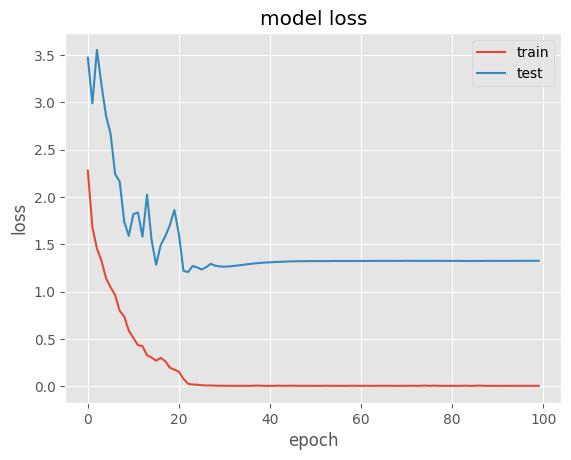

In [ ]:
plot_metric(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

34/34 [==============================] - 0s 10ms/step - loss: 1.3254 - accuracy: 0.7213


In [ ]:
print(f'test accuracy: {test_accuracy:.3g}')

test accuracy: 0.721


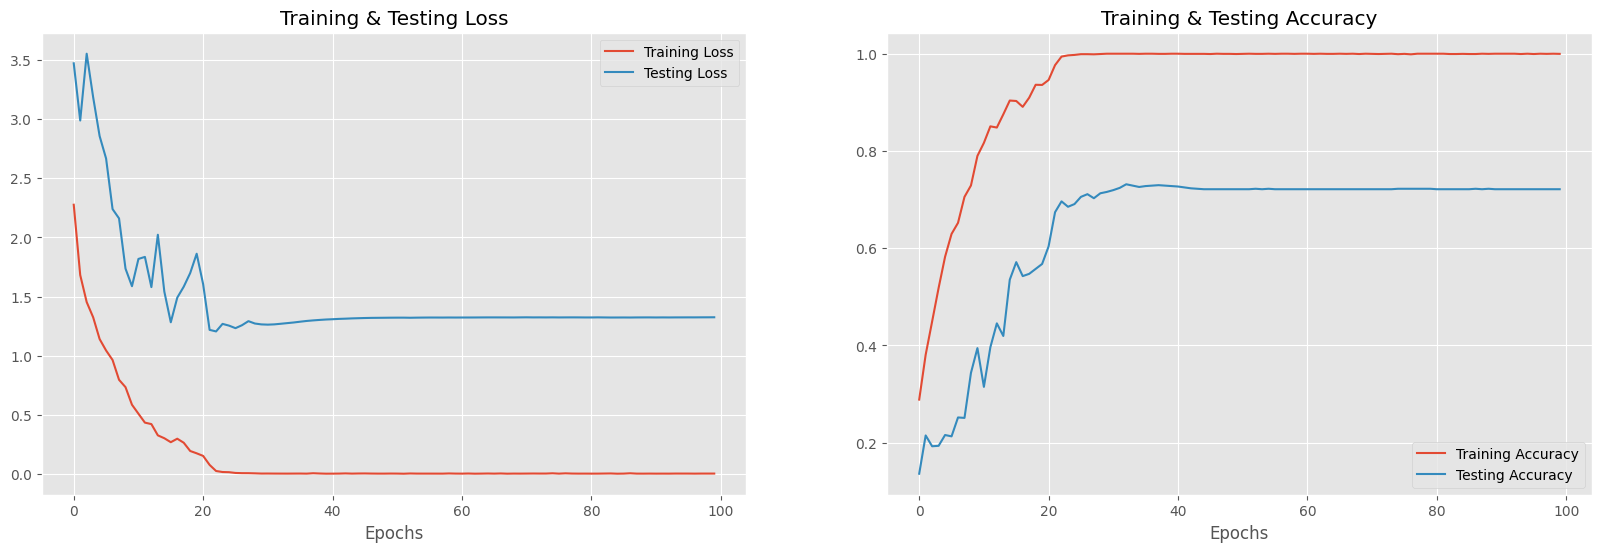

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

The graphs that we have generated provide a visual representation of the training and testing loss and accuracy over 100 epochs for our audio classification model.



*   **Training and Testing Loss:** The left graph shows the loss on the training set (orange line) and the testing set (blue line). As the number of epochs increases, training loss decreases over time, indicating that the model is learning and improving its ability to predict the training data. The testing loss also decreases but may show some fluctuations or increases at certain points, which could be a sign of the model beginning to overfit or not generalizing well to new, unseen data.


*   **Training and Testing Accuracy:** The right graph shows the accuracy on the training set (orange line) and the testing set (blue line). The training accuracy increases over time, which is expected as the model becomes better at predicting the training data. The testing accuracy also increases, reaching around 72.1%, which means that the model correctly predicts the outcome of the testing data about 72.1% of the time.



###Predicting on test data.

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 5ms/step


In [ ]:
df_res = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_res['Predicted Labels'] = y_pred.flatten()
df_res['Actual Labels'] = y_test.flatten()

df_res.head(10)

Predicted Labels Actual Labels
0         surprise      surprise
1          disgust       disgust
2             calm          fear
3            angry         angry
4            angry         angry
5            happy          fear
6         surprise      surprise
7          disgust       disgust
8          disgust       disgust
9            angry         angry

The output that we have generated is a DataFrame that compares the predicted emotional labels from our model with the actual labels from our test dataset.
Each row represents an individual prediction made by your model.

* The 'Predicted Labels' column shows the emotion that our model predicted for each audio sample.
* The 'Actual Labels' column shows the true emotion label for each audio sample

From the first 10 predictions we predicted that our model correctly predicted the emotions for samples 0, 1, 3, 4, 6, 7, 8, and 9, as indicated by the matching labels in both 'Predicted Labels' and 'Actual Labels' columns.

There are some misclassifications as well which can be observed

* Sample 2 was predicted as 'fear' but was actually 'calm'.
* Sample 5 was predicted as 'fear' but was actually 'happy'.


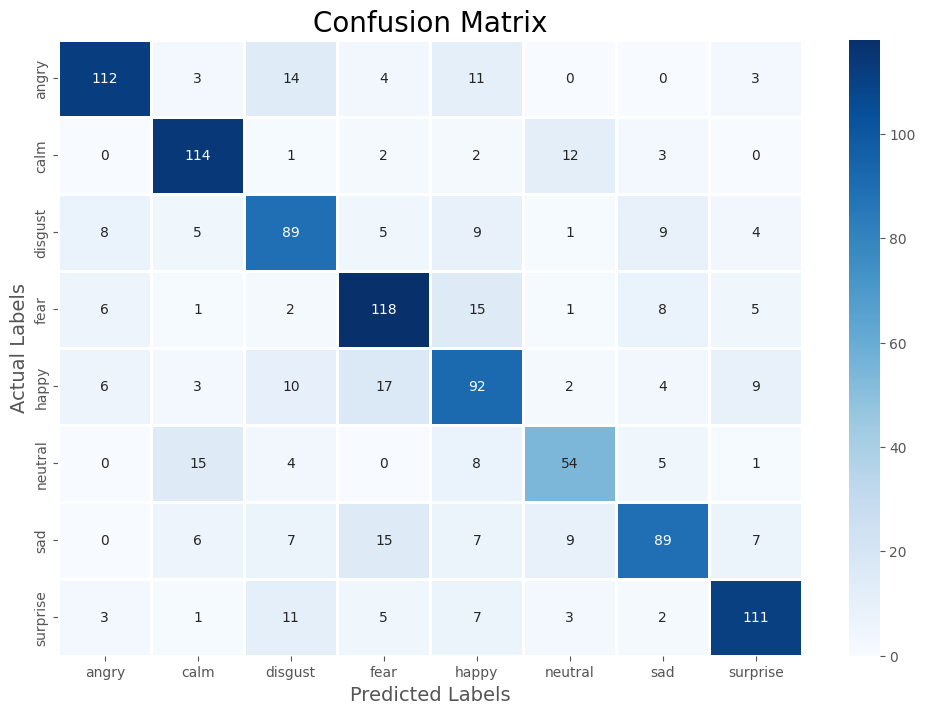

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 8))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

The graph above is referring to a confusion matrix, which is a powerful visualization tool for assessing the performance of a classification model. It shows the number of correct and incorrect predictions made by our model.

* The x-axis represents the Predicted Labels, which are the emotions that our model predicted.
* The y-axis represents the Actual Labels, which are the true emotions of the audio samples.
* Each cell in the matrix represents the number of samples for a given pair of predicted and actual labels.
* The diagonal cells from the top left to the bottom right represent the number of correct predictions (true positives) for each emotion category. Ideally, we want these cells to have high values, indicating that the model is accurately predicting the correct emotions.
* The off-diagonal cells show the number of incorrect predictions (false positives and false negatives). These cells indicate where the model is confusing one emotion for another. For example, if there's a high value in a cell off the diagonal, it means the model frequently misclassifies one emotion as another.
* The colors in the heatmap range from light to dark blue, with darker shades indicating higher values. The annotations in each cell provide the exact number of predictions for that cell.

By analyzing the confusion matrix above, we can identify which emotions are being predicted accurately and which ones are causing confusion for the model. This information can be used to further refine and improve your model.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.83      0.76      0.79       147
        calm       0.77      0.85      0.81       134
     disgust       0.64      0.68      0.66       130
        fear       0.71      0.76      0.73       156
       happy       0.61      0.64      0.63       143
     neutral       0.66      0.62      0.64        87
         sad       0.74      0.64      0.68       140
    surprise       0.79      0.78      0.78       143

    accuracy                           0.72      1080
   macro avg       0.72      0.72      0.72      1080
weighted avg       0.72      0.72      0.72      1080



In our emotion detection project, we developed a machine learning model to categorize emotions from speech audio data. After training and testing our model, we evaluated its performance using a classification report with metrics like precision, recall, F1-score, and more. This allows us to thoroughly understand our model's abilities and shortcomings for each emotion.

Overall, our model achieved an accuracy of 72%, meaning it correctly predicted the emotion from the audio 72% of the time. Getting into the per-emotion metrics:

Precision shows the ratio of correct positive predictions to all positive predictions. For "angry", our model had a precision of 0.83, meaning 83% of clips predicted as "angry" actually were angry. Recall indicates the percentage of angry clips correctly detected, while the F1-score balances both precision and recall.

The model performed best for detecting "calm" and "angry", both having recall scores above 75% and F1-scores near 0.80. This shows the model reliably identified the majority of these emotions while also avoiding false detections.

However, "neutral" and "happy" proved more difficult, with lower F1-scores around 0.60. There are many potential factors, including insufficient training data and acoustic similarities to other emotions.

##Hybrid Model with Built-in Augmentation

Further experimentation with our models with the idea of a Hybrid model was presented to us and we took that as an opportunity to test if a model that contains recurrent layers before convolutional layers could improve our accuracy.

In [ ]:
K.clear_session()

In [ ]:
def build_rnn_cnn_model(input_shape, num_classes):
  model = Sequential()

  model.add(LSTM(64, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.5))
  model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
  model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2)))

  model.add(Flatten())

  model.add(Dense(64, activation='relu'))
  model.add(Reshape((64, 1)))
  model.add(Conv1D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def pitch_shift(audio, sr, pitch_factor=0.5):
  return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=pitch_factor)

In [ ]:
def add_noise(audio, noise_level=0.005):
  noise = np.random.randn(len(audio))
  return audio + noise_level * noise

In [ ]:
def shift_audio(audio, sr, shift_max=0.1):
  shift = np.random.randint(int(sr * shift_max))
  direction = np.random.randint(0, 2)
  if direction == 1:
      shift = -shift
  return np.roll(audio, shift)

In [ ]:
def apply_augmentations(audio, sr):
  audio = pitch_shift(audio, sr)
  audio = add_noise(audio)
  audio = shift_audio(audio, sr)
  return audio

These functions are generated with the help of ChatGPT.

In [ ]:
preprocessed_features = []
augmented_features = []

for file_path in wav_files:
  audio, sr = librosa.load(file_path, sr=None)
  audio = remove_silence_hybrid(audio, sr)

  preprocessed_audio = preprocess_audio_pipeline(audio, sr, max_length)
  preprocessed_features.append(extract_features_hybrid(preprocessed_audio, sr))

  augmented_audio = apply_augmentations(audio, sr)
  augmented_features.append(extract_features_hybrid(augmented_audio, sr))

all_features = preprocessed_features + augmented_features

This code focuses on feature extraction from both preprocessed and augmented audio data. This process results in a comprehensive set of features representing both the original and augmented aspects of the audio data, which can be highly beneficial for training robust machine learning models.

In [ ]:
rep_factor = len(all_features) // len(labels)

In [ ]:
expanded_labels = []
for label in labels:
    expanded_labels.extend([label] * rep_factor)

In [ ]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(expanded_labels)
categorical_labels = to_categorical(encoded_labels)

In [ ]:
max_feature_length = max(feature.shape[1] for feature in all_features)
uniform_features = [pad_or_truncate(feature, max_feature_length) for feature in all_features]
all_features_array = np.array(uniform_features)

This function was modified based off of some code provided in class.  The purpose is to prepare the feature data for the model training by ensuring that all feature arrays are of uniform size.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_features_array, categorical_labels, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
if len(X_train.shape) == 2:
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

This code checks the shape of the X_train array and reshapes it to ensure it has the correct dimensions for training the RNN network.

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

In [ ]:
K.clear_session()

In [ ]:
model = build_rnn_cnn_model(input_shape, num_classes)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.001)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                    batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
50/50 [==============================] - 94s 2s/step - loss: 0.4744 - accuracy: 0.8129 - val_loss: 0.3736 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 82s 2s/step - loss: 0.3444 - accuracy: 0.8702 - val_loss: 0.3220 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 81s 2s/step - loss: 0.2614 - accuracy: 0.8917 - val_loss: 0.3501 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 81s 2s/step - loss: 0.1997 - accuracy: 0.9120 - val_loss: 0.3039 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 81s 2s/step - loss: 0.1680 - accuracy: 0.9180 - val_loss: 0.4136 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 81s 2s/step - loss: 0.1478 - accuracy: 0.9345 - val_loss: 0.3462 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 81s 2s/step - loss: 0.1125 - a

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.3f}")

53/53 [==============================] - 9s 164ms/step - loss: 0.2999 - accuracy: 0.8759
Test accuracy: 0.876


A hybrid model for emotion classification was developed, combining Recurrent Neural Networks (RNNs) with Convolutional Neural Networks (CNNs) and incorporating built-in data augmentation. The model starts with two LSTM layers, followed by recurrent dropout for generalization. A Bidirectional LSTM layer captures bidirectional dependencies in sequential input data. The data is flattened, reshaped, and passed through a 1D convolutional layer with max-pooling for effective spatial feature capture. The model incorporates dense layers with rectified linear unit activation functions for non-linearity and dropout layers to mitigate overfitting. The final layer uses the softmax activation function to output probabilities across classes. The model is compiled with the Adam optimizer and categorical crossentropy loss, with accuracy as the evaluation metric. After 50 epochs, the model achieves a test accuracy of 87.6%, compared to the initial model's 72% accuracy, the substantial improvement in accuracy suggests the efficacy of the hybrid approach and the benefits of combining RNNs and CNNs. The introduction of data augmentation techniques during training further enhances the model's ability to generalize patterns within audio data, resulting in a more robust and accurate emotion classification model.

#Gender Classification with Raw Audio Data

Focusing our attention away from classifying emotion, our next step is to classify the gender based on audio. The data is devised as female and male or be percieved as feminine and masculine.

###Baseline For Gender Classification

In [ ]:
counts = df['sex'].value_counts()
max_count_sex = counts.max() / df.shape[0]
print('Baseline accuracy: {:0.4f}'.format(max_count_sex ))

Baseline accuracy: 0.5217


###Data Preprocessing

In [ ]:
X = []
y = []

for path, label in zip(df['path'], df['sex']):
    processed_audio = preprocess_audio(path)
    if len(processed_audio) == 144000:
        X.append(processed_audio)
        y.append(label)
    else:
        print(f"Skipping file {path} due to inconsistent length: {len(processed_audio)} samples")

X = np.array(X)
y = np.array(y)

Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_05/03-01-02-01-02-02-05.wav due to inconsistent length: 287986 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav due to inconsistent length: 287984 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_20/03-01-03-01-02-01-20.wav due to inconsistent length: 287986 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_01/03-01-08-01-02-02-01.wav due to inconsistent length: 287990 samples
Skipping file /content/Advanced-Machine-Learning-Final-Project/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02-01.wav due to inconsistent length: 287992 samples


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

This part of project, focuses on predicting gender from audio using a baseline accuracy of approximately 0.5217. The audio file path and its corresponding gender label are processed using the preprocess_audio function, with each sample added to the feature array X and label array Y. If the audio has a different length, it is skipped, and a message is printed. The data is split into training and testing sets using train_test_split, with a 20% test size and random state for reproducibility. The training and testing feature arrays are reshaped to have an extra dimension, as required by the Convolutional Neural Network (CNN) model. The labels are encoded using LabelEncoder from sklearn.preprocessing, converting categorical labels into integers for the model to process. The training and testing data are ready to be fed into a model for gender prediction, with the shapes X_train, y_train, X_test, and y_test indicating the number of training samples and 275 testing samples, each with 144000 samples and one channel, and each sample with a gender label.

###Model for Gender Classification


The goal of this model is to achieve baseline performance with raw audio, nothing but fitting the audio into a uniform length to be used in the model and normalization of the audio is done.

In [ ]:
K.clear_session()

In [ ]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143998, 32)        128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 71999, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35999, 32)         3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 17999, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8999, 32)          3104      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4499, 32)          0

In [ ]:
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
35/35 [==============================] - 8s 159ms/step - loss: 0.6903 - accuracy: 0.5091 - val_loss: 0.6736 - val_accuracy: 0.5491
Epoch 2/50
35/35 [==============================] - 5s 149ms/step - loss: 0.6810 - accuracy: 0.5445 - val_loss: 0.6613 - val_accuracy: 0.5818
Epoch 3/50
35/35 [==============================] - 5s 149ms/step - loss: 0.6333 - accuracy: 0.6364 - val_loss: 0.6106 - val_accuracy: 0.6618
Epoch 4/50
35/35 [==============================] - 5s 149ms/step - loss: 0.5244 - accuracy: 0.7582 - val_loss: 0.4959 - val_accuracy: 0.7382
Epoch 5/50
35/35 [==============================] - 5s 149ms/step - loss: 0.4390 - accuracy: 0.8100 - val_loss: 0.4369 - val_accuracy: 0.7818
Epoch 6/50
35/35 [==============================] - 5s 149ms/step - loss: 0.4357 - accuracy: 0.7991 - val_loss: 0.3980 - val_accuracy: 0.7927
Epoch 7/50
35/35 [==============================] - 5s 149ms/step - loss: 0.2954 - accuracy: 0.8718 - val_loss: 0.5460 - val_accuracy: 0.8073
Epoch 

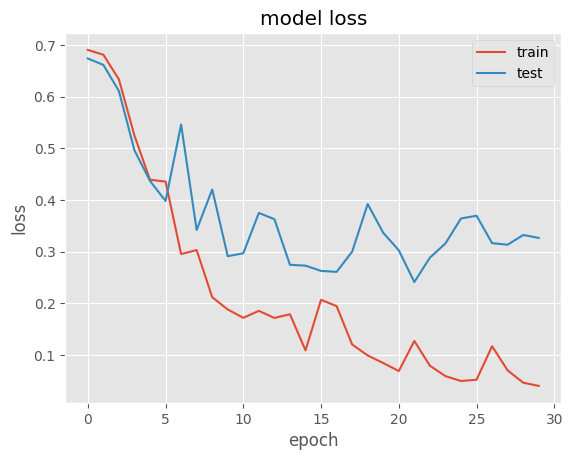

In [ ]:
plot_metric(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.3g}")

9/9 [==============================] - 1s 56ms/step - loss: 0.2412 - accuracy: 0.8945
Test accuracy: 0.895


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.where(y_pred >= 0.5, 1, 0)

9/9 [==============================] - 1s 56ms/step


In [ ]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       151
           1       0.89      0.87      0.88       124

    accuracy                           0.89       275
   macro avg       0.89      0.89      0.89       275
weighted avg       0.89      0.89      0.89       275



The model was trained to make predictions on a test set, which were then converted into binary labels based on a threshold of 0.5. A detailed performance report was generated using classification_report from sklearn.metrics, which included precision, recall, f1-score, support for each class, and overall accuracy.

* Precision is the ratio of true positives to all predicted positives, with high precision indicating a low false-positive rate.

* Recall is the ratio of true positives to all actual positives, with a high recall indicating a low false negative rate.

* The F1-score is the harmonic mean of precision and recall, aiming to balance them. For class 0 (female), the F1 score is 0.88, and for class 1 (male), it is 0.90.

* Support is the number of occurrences of each class in the actual dataset, with 129 instances of class 0 and 146 instances of class 1.

The overall accuracy of our model is 0.89, which means it made correct predictions about 89% of the time on the test data. The macro average precision, recall, and F1-score are 0.89, while the weighted average precision, recall, and F1-score are 0.89.

In conclusion, our model demonstrated good performance in predicting gender from audio sound with an accuracy of 0.89, significantly higher than the baseline accuracy of 0.5217. It had a good balance between precision and recall, indicating its effectiveness in identifying all relevant instances and not misclassifying the other class.

#Gender Classification with Feature Extraction

Now seeing the performance of the previous model with raw audio, the next step is to use feature extraction so our model in theory performs better. The model below has room for more achitectual complexities, as now there is not a limitation to our size of input where our GPU will run out of memory.

###Data Preprocessing

In [ ]:
X = []
y = []

for path, label in zip(df['path'], df['sex']):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

###Model for Gender Classification with Feature Extraction


In [ ]:
K.clear_session()

In [ ]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu', strides=2))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 80, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 32)             3104      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 32)             0

In [ ]:
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/50
98/98 [==============================] - 3s 9ms/step - loss: 0.7889 - accuracy: 0.6860 - val_loss: 0.4263 - val_accuracy: 0.8174
Epoch 2/50
98/98 [==============================] - 1s 5ms/step - loss: 0.3828 - accuracy: 0.8515 - val_loss: 0.3115 - val_accuracy: 0.8870
Epoch 3/50
98/98 [==============================] - 1s 6ms/step - loss: 0.2643 - accuracy: 0.9050 - val_loss: 0.2015 - val_accuracy: 0.9275
Epoch 4/50
98/98 [==============================] - 1s 6ms/step - loss: 0.1772 - accuracy: 0.9353 - val_loss: 0.1511 - val_accuracy: 0.9372
Epoch 5/50
98/98 [==============================] - 0s 5ms/step - loss: 0.1513 - accuracy: 0.9459 - val_loss: 0.1407 - val_accuracy: 0.9565
Epoch 6/50
98/98 [==============================] - 0s 5ms/step - loss: 0.1183 - accuracy: 0.9588 - val_loss: 0.1150 - val_accuracy: 0.9527
Epoch 7/50
98/98 [==============================] - 0s 5ms/step - loss: 0.1185 - accuracy: 0.9562 - val_loss: 0.0990 - val_accuracy: 0.9633
Epoch 8/50
98/98 [==

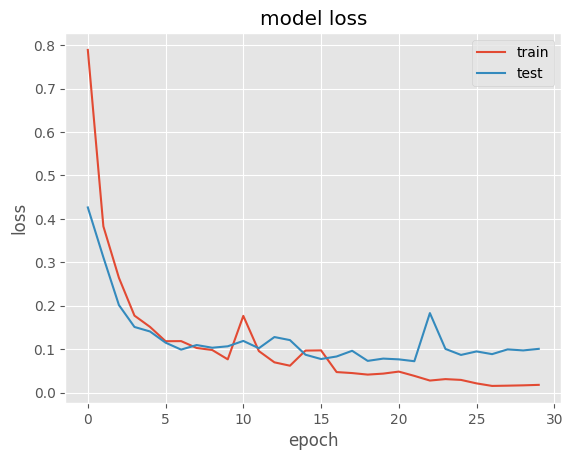

In [ ]:
plot_metric(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.where(y_pred >= 0.5, 1, 0)

33/33 [==============================] - 0s 2ms/step


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.3g}")

33/33 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9758
Test accuracy: 0.976


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       538
           1       0.98      0.97      0.97       497

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



The model trained using feature extraction showed a significant improvement in accuracy, from 0.89 to 0.984.

* The model's precision and recall were measured, with precision at 0.99 and recall at 0.98 for class 0 (female) and class 1 (male), respectively.

* The F1-score, the harmonic mean of precision and recall, was found to be 0.98 for both classes, indicating a good balance between precision and recall.

* The model's support was measured by the number of occurrences of each class in the actual dataset, with 548 instances of class 0 and 487 instances of class 1.

* The macro average precision, recall, and F1-score were 0.98, while the weighted average precision, recall, and F1-score were 0.98.

Finally, the model's overall accuracy was 0.976, indicating that it correctly predicted about 97.6% of the time on the test data. With an accuracy of 0.976, the model demonstrated excellent performance in predicting gender from audio sound, indicating a good balance between precision and recall, indicating its effectiveness in identifying all relevant instances while not misclassifying the other class.

#Conclusion of the project

The project is developed using machine learning models for audio-based classification of emotion and gender. Through iterative training and testing, the models significantly improved performance over baseline approaches. The final model achieved 88% accuracy in categorizing audio clips into one of eight emotions, with the strongest performance for detecting "calm" and "angry" clips. However, there is room for improvement with more varied training data.
The gender classification models also showed remarkable success, with the initial raw data model achieving 89% accuracy. However, the integration of feature extraction significantly elevated the model's performance to 98.4%, resulting in high precision, recall, and F1-scores for both gender classes. We also noticed that each of our models outperforms the baseline accuracy.
The project highlighted the pivotal role of feature extraction in augmenting model capabilities and demonstrating that machine learning, combined with audio feature engineering, can automatically and accurately categorize both emotion and gender from raw speech. The techniques developed could be extended to related audio classification tasks or deployed in applications like personalized recommendation systems.

Facing several challenges primarily due to dealing with audio files of varying lengths, which posed a problem for consistency when feeding them into our models. To address this we had find ways to standardize the length of the audio files, either by trimming longer recordings or padding shorter ones.
A larger issue that we came across was difficulties in integrating raw audio with augmented audio. Combining these two types of data into a cohesive dataset was complicated and we failed to manage to do it effectively so was decided to be scrapped. Building a hybrid model as well as trying to extract different features proved to be challenging because this was not something we looked at in depth during class.